# Assignment 2 : Projection & Triangulation

---
Please edit the cell below to include your name and student ID #

**name:**Mutian Xu

**SID:**16083274

# 1. Cameras 

Please write out your answers in the empty cells below each question.  Feel free to include images, diagrams or equations as needed to explain your answer. For written answers, you can create nicely typeset equations in the notebook using MathJax/Latex (see 
https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html)


# ***
### 1.1 Field of View [5pts]
Suppose your camera has an image sensor that is 1280 pixels wide and 1024 pixels tall with a physical resolution of 15pixels/mm and a focal length of f=50mm. **(a)** What is the horizontal field of view (in degrees)? **(b)** What is the vertical field of view? **(c)** Suppose you adjust the zoom on the camera, changing the focal length to 100mm. What is the new horizontal field of view? 

***your answers go here***

(a) HFOV(in degrees)=2*arctan(h/(2*f))=2*arctan((1024/15)/(2*50))=68.64

(b) VFOV(in degrees)=2*arctan(w/(2*f))=2*arctan((1280/15)/(2*50))=80.95

(c) HFOV_new(in degrees)=2*arctan(h/(2*f))=2*arctan((1024/15)/(2*100))=37.69

***
### 1.2  Camera motions [5pts]

Your camera starts out at the origin of the world coordinate system where as you stand holding the camera, the x-axis is pointed to the right, the y-axis is pointed down and z-axis is pointed out of the camera away from you.  You rotate the camera to the right about the y-axis by 90 degrees (clockwise looking down on the camera from above) and then translate it left along the x-axis by 2 meters.   **(a)** Describe this motion of the camera concisely by specifying the rotation matrix and translation vector corresponding to this motion.  **(b)** Suppose there is a point with coordinates (2,2,2) meters in the world coordinate system.  What will its coordinates be relative to the camera coordinate system after the camera has been moved?

***your answers go here***
(a) R=[[cos(theta),0,-sin(theta)],[0,1,0],[sin(theta),0,cos(theta)]]=[[0,0,-1],[0,1,0],[1,0,0]]

t=[[-2],[0],[0]]

(b) P=R^-1*(P_world-t)=(-2,2,4)

code:import numpy as np

Rx=np.array([[1,0,0],[0,1,0],[0,0,1]])

Ry=np.array([[0,0,-1],[0,1,0],[1,0,0]])

Rz=np.array([[1,0,0],[0,1,0],[0,0,1]])

R=Rx@Ry@Rz

t=np.array([[2],[0],[0]])

R_inv=np.linalg.inv(R)

P=np.array([[2],[2],[2]])

print(R_inv@(P-t))

***
# 2. Projection

### 2.1 Implement Projection [30pts]

The code below outlines a simple python class that encapsulates the parameters of a camera. Write a function **project** which carries out the operation of projection with this camera. Your function should take as input the coordinates of a set of points in 3D, carry out projection based on the camera's parameters, and return the 2D coordinates of where those points would appear in the image. 

One approach is to combine all the camera parameters into a single 3x4 camera matrix as we discussed in class. However, for the purpose of the assignment it is sufficient to simply carry out each step separately (i.e., convert from global to camera coordinate system, project into camera, scale by focal length and offset by principal point). In either case, your code **should not** involve any for-loops over individual points.  Instead please carry out the computation using vectorized numpy operations. 


In [38]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import visutils  #provided visutils.py contains some helper functions for 3d plots

In [39]:
class Camera:
    """
    A simple data structure describing camera parameters 
    
    The parameters describing the camera
    cam.f : float   --- camera focal length (in units of pixels)
    cam.c : 2x1 vector  --- offset of principle point
    cam.R : 3x3 matrix --- camera rotation
    cam.t : 3x1 vector --- camera translation 

    
    """    
    def __init__(self,f,c,R,t):
        self.f = f
        self.c = c
        self.R = R
        self.t = t

        
    def project(self,pts3):
        """
        Project the given 3D points in world coordinates into the specified camera    

        Parameters
        ----------
        pts3 : 2D numpy.array (dtype=float)
            Coordinates of N points stored in a array of shape (3,N)

        Returns
        -------
        pts2 : 2D numpy.array (dtype=float)
            Image coordinates of N points stored in an array of shape (2,N)

        """

        assert(pts3.shape[0]==3)

        #
        # your code goes here
        #
        
        #convert from global to camera coordinate system
        n=pts3.shape[1]
        R_inv=np.linalg.inv(self.R)
        pts_cam=R_inv@(pts3-self.t)
        #project into camera,scale by focal length and offset by principal point offsetoffset
        pts_proj=np.array([[self.f,0,self.c[0]],[0,self.f,self.c[1]],[0,0,1]])@pts_cam
        pts2_1=pts_proj/pts_proj[-1]
        pts2=(np.delete(pts2_1,2,0))
        
        
        assert(pts2.shape[1]==pts3.shape[1])
        assert(pts2.shape[0]==2)
    
        return pts2
    

### 2.2 Testing projection [10pts]

To test your camera projection operation, we will create a synthetic scene, place the camera in the scene, and visualize the resulting "image" of the scene. The function provided below, ***generate_hemisphere*** creates a set of 3d points randomly distributed on the surface of a hemisphere. We use this to construct a simple test scene and visualize the result of calling your ***project*** function.

For the scene geometry, generate 500 points on a hemisphere of radius 1 centered at [5,0,5]. For the camera, place the camera at the origin [0,0,0] and rotate the camera so that the camera is looking directly at the center of the hemisphere. Let's suppose our camera has a 100x100 pixel sensor. Select the focal length and principal point of the camera so that the image of the hemisphere points is 100 pixels tall and centered in the image (i.e., the projected points should all fall in the square [0-100]x[0-100])


In [40]:
def generate_hemisphere(radius,center,npts):
    """
    Generate a set of 3D points which are randomly distributed on the
    surface of a hemisphere for purposes of testing your code.
    
    Parameters
    ----------
    radius : float
        Hemisphere radius

    center : numpy.array (dtype=float)
        3x1 vector specifying the center of the hemisphere
        
    npts : int
        number of points to generate

    Returns
    -------
    x : 2D numpy.array (dtype=float)
        (3,npts) array containing coordinates of the points
        
    """
    
    assert(center.shape==(3,1))
    
    #generate randomly distributed points
    x = np.random.standard_normal((3,npts))
    
    #scale points to the surface of a sphere with given radius
    nx = np.sqrt(np.sum(x*x,axis=0))
    x = radius * x / nx
    
    # make points with positive z-coordinates negative
    # so that points are all on a half-sphere 
    x[2,:] = -np.abs(x[2,:])
    
    # translate to desired position
    x = x + center
    
    return x

<IPython.core.display.Javascript object>


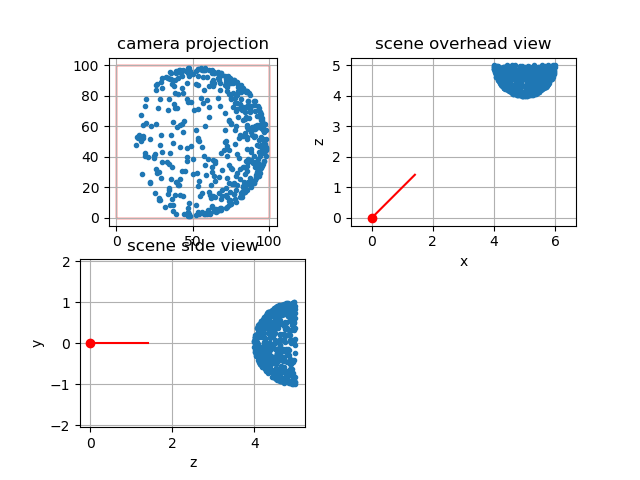

Text(0.5, 1.0, 'scene side view')

In [41]:
#
# test your camera and project function
#

# generate 500 3D points on a hemisphere of radius 1 at
# a location 5 units along the z axis and 5 units along
# the x axis.
pts3 = generate_hemisphere(1,np.array([[5],[0],[5]]),500)

# create the camera with the desired parameters
f = 340
c = np.array([[50],[50]])
theta = np.radians(-45)
Rx = np.array([[1,0,0],[0,1,0],[0,0,1]])
Ry = np.array([[np.cos(theta),0,-np.sin(theta)],[0,1,0],[np.sin(theta),0,np.cos(theta)]])
Rz = np.array([[1,0,0],[0,1,0],[0,0,1]])
R = Rx@Ry@Rz
t = np.array([[0],[0],[0]])
cam = Camera(f,c,R,t)

# call the project function to see where the points
# appear in the camera image
pts2 = cam.project(pts3)


#
# Visualize results.  You do not need to change the code below, but
# make sure you understand it so you can use it in the future to 
# perform your own visualizations.
#

# generate coordinates of a line segment running from the center
# of the camera to 2 units in front of the camera along the z-axis
# this is useful for visualizing what direction the camera is pointed
# at in the plots below
look = np.hstack((cam.t,cam.t+cam.R @ np.array([[0,0,2]]).T))

# visualize the image of the points in the camera
# draw a square [0,100]x[0,100] designating the box
# we want the hemisphere to fall inside of
fig = plt.figure()
ax = fig.add_subplot(2,2,1)
ax.plot(pts2[0,:],pts2[1,:],'.')
ax.add_patch(patches.Rectangle((0,0),100,100,color='r',fill=False))
plt.grid()
plt.axis('square')
plt.title('camera projection')

# overhead view (xz-plane) showing points, camera
# position, and direction camera is pointed
ax = fig.add_subplot(2,2,2)
ax.plot(pts3[0,:],pts3[2,:],'.')
ax.plot(cam.t[0],cam.t[2],'ro')
ax.plot(look[0,:],look[2,:],'r')
plt.axis('equal')
plt.grid()
plt.xlabel('x')
plt.ylabel('z')
plt.title('scene overhead view')

# side view (yz-plane) showing points, camera
# position, and direction camera is pointed
ax = fig.add_subplot(2,2,3)
ax.plot(pts3[2,:],pts3[1,:],'.')
ax.plot(cam.t[2],cam.t[1],'ro')
ax.plot(look[2,:],look[1,:],'r')
plt.axis('equal')
plt.grid()
plt.xlabel('z')
plt.ylabel('y')
plt.title('scene side view')


# 3. Triangulation 

## 3.1 Implementing Triangulation [40pts]

Write a function called **triangulate** that takes the coordinates of points in two images along with the camera parameters and returns the 3D coordinates of the points in world coordinates.  Please use the least-squares technique we described in class.  You can use **np.linalg.lstsq** to get the least-squares estimate of the z coordinates for each point. Since the linear system is independent for each point, it is fine to use a for-loop over the points to be triangulated. 

The solution we described in the Lecture 4 slides assumes the right camera is at the world coordinate origin.  To make this work for cameras in general position (neither camera at the origin), you will first need to determine the relative pose between the two cameras, solve the least squares problem to get the z-coordinates and then transform the solution back to the world coordinate system. Please refer to class notes and slides.



In [42]:
def triangulate(pts2L,camL,pts2R,camR):
    """
    Triangulate the set of points seen at location pts2L / pts2R in the
    corresponding pair of cameras. Return the 3D coordinates relative
    to the global coordinate system


    Parameters
    ----------
    pts2L : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (2,N) seen from camL camera

    pts2R : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (2,N) seen from camR camera

    camL : Camera
        The first "left" camera view

    camR : Camera
        The second "right" camera view

    Returns
    -------
    pts3 : 2D numpy.array (dtype=float)
        (3,N) array containing 3D coordinates of the points in global coordinates

    """

    #
    # Your code goes here.  I recommend adding assert statements to check the
    # sizes of the inputs and outputs to make sure they are correct 
    #
    assert(pts2L.shape[0]==pts2R.shape[0])
    assert(pts2L.shape[0]==2)
    
    #convert from pixel coordinates into image coordinates
    #subtract c and add a ones array to get the homogeneous coord
    ones = np.ones((1,pts2L.shape[1]))
    qL = np.vstack(((pts2L-camL.c)/camL.f,ones))
    qR = np.vstack(((pts2R-camR.c)/camR.f,ones))
    
 
    #use np.linalg.lstsq to get the least-squares estimate of the z coordinates
    #use the equation of class notes
    pts3_L = np.zeros(shape=(3,pts2R.shape[1]))
    pts3_R = np.zeros(shape=(3,pts2R.shape[1]))
    for i in range(pts2R.shape[1]):
        a = camL.R@(qL[:,i].reshape(3,1))
        b = -camR.R@(qR[:,i].reshape(3,1))
        Zl,Zr = np.linalg.lstsq(np.hstack((a,b)),camR.t-camL.t)[0]      
        #use z back to relative coord caculation to get pts3
        pts3_L[:,i] = (camL.R@(Zl*qL[:,i]).reshape(3,1)+camL.t).reshape(3) #pts3 caculated by left camera
        pts3_R[:,i] = (camR.R@(Zr*qR[:,i]).reshape(3,1)+camR.t).reshape(3) #pts3 caculated by right camera
        
    pts3 = (pts3_L + pts3_R)/2 #the final pts3 should be the average of two values caculated on last step
    
    assert(pts3.shape[1]==pts2R.shape[1])
    assert(pts3.shape[0]==3)
    return pts3

## 3.2 Testing Triangulation [10pts]

The provided code below creates a simple test case of two cameras offset to the right and left of the origin and rotated to point at a hemisphere placed some distance from the origin along the z-axis.  It calls your **project** function to generate the left and right image and then calls your **triangulate** function to recover the 3D point locations. This corresponds to the "noise free" case where our camera calibration and point localization are perfect by construction.

You should **(a)** understand and run the code below to verify that when you triangulate the two sets of points you get back the original 3D locations.  **(b)** Write an additional block of code which triangulates the exact same set of 2D points (pts2L,pts2R) but calls your triangulation code passing it a poorly calibrated camera. You can simulate this by adjusting the focal length of camL to be 10% larger. Visualize the 3D reconstruction of the perfectly calibrated cameras and the poorly calibrated cameras. **(c)** to quantify the error in the reconstruction, compute the average over all points of the distance between the true 3D location and the reconstruction 3D location. Report this average error for the perfect case (it should be close to 0) and for the case where the focal length is off by 10%.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<IPython.core.display.Javascript object>


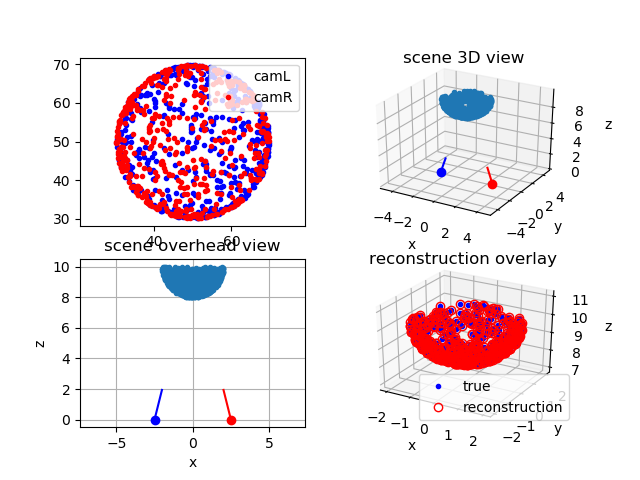

In [44]:
#
# create a test scene with two cameras 
#

# utility function to create a rotation matrix representing rotation 
# around y-axis by amount theta
def roty(theta):
    st = np.sin(theta)
    ct = np.cos(theta)
    R = np.array([[ct,0,st],[0,1,0],[-st,0,ct]])
    return R

#compute rotation angle so that the camera is centered on the sphere
b = 5  #baseline between cameras
d = 10   #distance to object
theta = np.arctan((b/2)/d)  #compute the rotation angle needed to point cameras at the hemisphere
tL = np.array([[-(b/2),0,0]]).T
tR = np.array([[(b/2),0,0]]).T
camL = Camera(f=100,c=np.array([[50,50]]).T,t=tL,R=roty(theta))
camR = Camera(f=100,c=np.array([[50,50]]).T,t=tR,R=roty(-theta))

#generate 3D points
pts3 = generate_hemisphere(2,np.array([[0,0,d]]).T,500)

#project into each camera
pts2L = camL.project(pts3)
pts2R = camR.project(pts3)

#triangulate to recover 3d position
pts3t = triangulate(pts2L,camL,pts2R,camR)

#
# visualize results
#

# generate coordinates of a line segment running from the center
# of the camera to 2 units in front of the camera
lookL = np.hstack((tL,tL+camL.R @ np.array([[0,0,2]]).T))
lookR = np.hstack((tR,tR+camR.R @ np.array([[0,0,2]]).T))

# visualize the left and right image overlaid
fig = plt.figure()
ax = fig.add_subplot(2,2,1)
ax.plot(pts2L[0,:],pts2L[1,:],'b.')
ax.plot(pts2R[0,:],pts2R[1,:],'r.')
plt.axis('equal')
plt.legend(('camL','camR'),loc=1)

#visualize 3D layout of points, camera positions
# and the direction the camera is pointing
ax = fig.add_subplot(2,2,2,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
ax.plot(tR[0],tR[1],tR[2],'ro')
ax.plot(tL[0],tL[1],tL[2],'bo')
ax.plot(lookL[0,:],lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[1,:],lookR[2,:],'r')
visutils.set_axes_equal_3d(ax)
visutils.label_axes(ax)
plt.title('scene 3D view')

# overhead view showing points, camera
# positions, and direction camera is pointed
ax = fig.add_subplot(2,2,3)
ax.plot(pts3[0,:],pts3[2,:],'.')
ax.plot(tL[0],tL[2],'bo')
ax.plot(lookL[0,:],lookL[2,:],'b')
ax.plot(tR[0],tR[2],'ro')
ax.plot(lookR[0,:],lookR[2,:],'r')
plt.axis('equal')
plt.grid()
plt.xlabel('x')
plt.ylabel('z')
plt.title('scene overhead view')

# compare reconstruction
ax = fig.add_subplot(2,2,4,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'b.')
ax.plot(pts3t[0,:],pts3t[1,:],pts3t[2,:],'ro',fillstyle='none')
visutils.set_axes_equal_3d(ax)
visutils.label_axes(ax)
plt.title('reconstruction overlay')
plt.legend(('true','reconstruction'),loc=4)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<IPython.core.display.Javascript object>


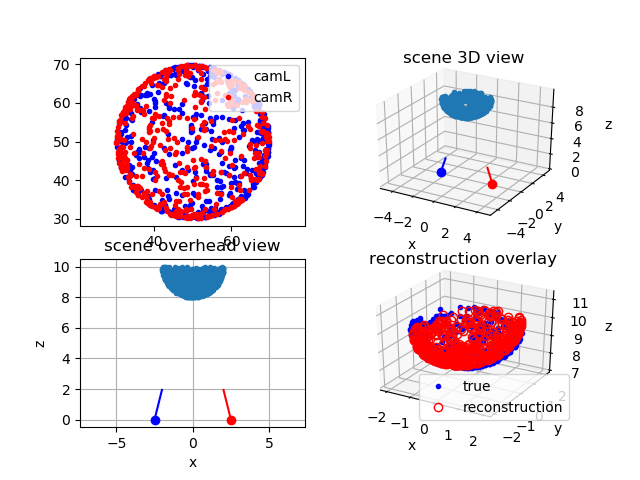

In [45]:
#
# triangulate the points again but modify camL so that the focal length
# is 10% larger than the true value used to produce the 2d points
#

camL_2 = Camera(f=110,c=np.array([[50,50]]).T,t=tL,R=roty(theta))
camR_2 = Camera(f=100,c=np.array([[50,50]]).T,t=tR,R=roty(-theta))
pts3t_badcalib = triangulate(pts2L,camL_2,pts2R,camR_2)


#
# visualize reconstruction compared to noise-free reconstruction.  
# how do they differ from each other??
#
# Answer: As shown below, it can be obviously seen that:
# The reconstruction with noise does not completely overlay with the original 3D hemisphere.

# visualize the left and right image overlaid
fig = plt.figure()
ax = fig.add_subplot(2,2,1)
ax.plot(pts2L[0,:],pts2L[1,:],'b.')
ax.plot(pts2R[0,:],pts2R[1,:],'r.')
plt.axis('equal')
plt.legend(('camL','camR'),loc=1)

#visualize 3D layout of points, camera positions
# and the direction the camera is pointing
ax = fig.add_subplot(2,2,2,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
ax.plot(tR[0],tR[1],tR[2],'ro')
ax.plot(tL[0],tL[1],tL[2],'bo')
ax.plot(lookL[0,:],lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[1,:],lookR[2,:],'r')
visutils.set_axes_equal_3d(ax)
visutils.label_axes(ax)
plt.title('scene 3D view')

# overhead view showing points, camera
# positions, and direction camera is pointed
ax = fig.add_subplot(2,2,3)
ax.plot(pts3[0,:],pts3[2,:],'.')
ax.plot(tL[0],tL[2],'bo')
ax.plot(lookL[0,:],lookL[2,:],'b')
ax.plot(tR[0],tR[2],'ro')
ax.plot(lookR[0,:],lookR[2,:],'r')
plt.axis('equal')
plt.grid()
plt.xlabel('x')
plt.ylabel('z')
plt.title('scene overhead view')

# compare reconstruction
ax = fig.add_subplot(2,2,4,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'b.')
ax.plot(pts3t_badcalib[0,:],pts3t[1,:],pts3t_badcalib[2,:],'ro',fillstyle='none')
visutils.set_axes_equal_3d(ax)
visutils.label_axes(ax)
plt.title('reconstruction overlay')
plt.legend(('true','reconstruction'),loc=4)


In [46]:
#
# compute the average reconstruction error (distance between the true 3D location and
# triangulated location, averaged over all the points) for both the perfect case (pts3t)
# and for the badly calibrated case (pts3t_badcalib) and print out the resulting errors
# in the notebook
#

#for perfect case:
print("for perfect case:",np.mean(pts3t-pts3, axis=1))

#for badly calibrated case:
print("for badly calibrated case:",np.mean(pts3t_badcalib-pts3, axis=1))

# Analysis: As shown below, compared with reconstruction error in perfect case,
# there is a 'big' error in badly calibrated case.

for perfect case: [ 5.79787954e-17 -3.79678927e-17  2.59348099e-16]
for badly calibrated case: [0.01037545 0.00055384 0.04672769]
